<a href="https://colab.research.google.com/github/Ansi4Ansi/Google_colab/blob/main/ML_B2C_2024_Q2_%7C_HW08_ML_generative_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #8: Генеративный ИИ

**Оформление ДЗ**:

- Выполненное ДЗ сохраните в файл ``ml_b2c2024q2_<Surname>_<Name>_HW#.ipynb``
  
  (пример ``ml_b2c2024q2__Dral_Alexey_HW01.ipynb``)
- Зарегистрироваться и залогиниться в сервисе [Everest](https://everest.distcomp.org/)
- Перейти на страницу приложения: [BDT-grader-ML-B2C](https://everest.distcomp.org/apps/BigDataTeam/BDT-grader-ML-B2C)
- Выбрать вкладку Submit Job (если отображается иная).
- Выбрать в качестве “Task” значение: `` ML_generative_ai`` (кодовое название для преподвателей: `` ML_generative_ai``)
- Загрузить в качестве “Task solution” файл с решением
- В качестве Access Token указать тот, который был выслан по почте или в телеграм от аккаунта @bdt_manager

**Дополнительные ссылки**
- Настройка локального окружения: https://github.com/big-data-team/ml-course
- Датасеты UCI: https://archive.ics.uci.edu/

**Вопросы**:
- Свои вопросы присылайте в Телеграм.

**Фидбек**:
- Пожалуйста, оставьте свой отзыв после выполнения домашнего задания по сссылке:

    https://forms.gle/iY5NRn9UfaZ344rbA

## Вопросы на понимание (10%)

1. Почему в автоэнкодерах не обязательно использование валидационной выборки?
2. Что произойдет с вариативным автоэнкодером, если убрать регуляризацию через KL-дивергенцию?
3. Допустим что при тренировке GAN модели, генератор обучается быстрее дискриминатора. Что произойдет с моделью?
4. Как выглядят процесс обучения и процесс генерации в диффузионных моделях?
5. Как считается мера ошибки при обучении CLIP?

## Конволюционные автоэнкодеры (20%)

Напишите вариант автоэнкодера для датасета MNIST, который будет использовать сверточные слои.

Для декодера вам пригодится слой `Conv2DTranspose`, который выполняет обратную операцию свертки.


Как вы оцените качество компрессии этой модели по сравнению с обычным полносвязным автоэнкодером? Какую модель Вы бы использовали для задачи сжатия изображений? Почему?

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid

%matplotlib inline

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2873974.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 465448.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4372873.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2989256.04it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



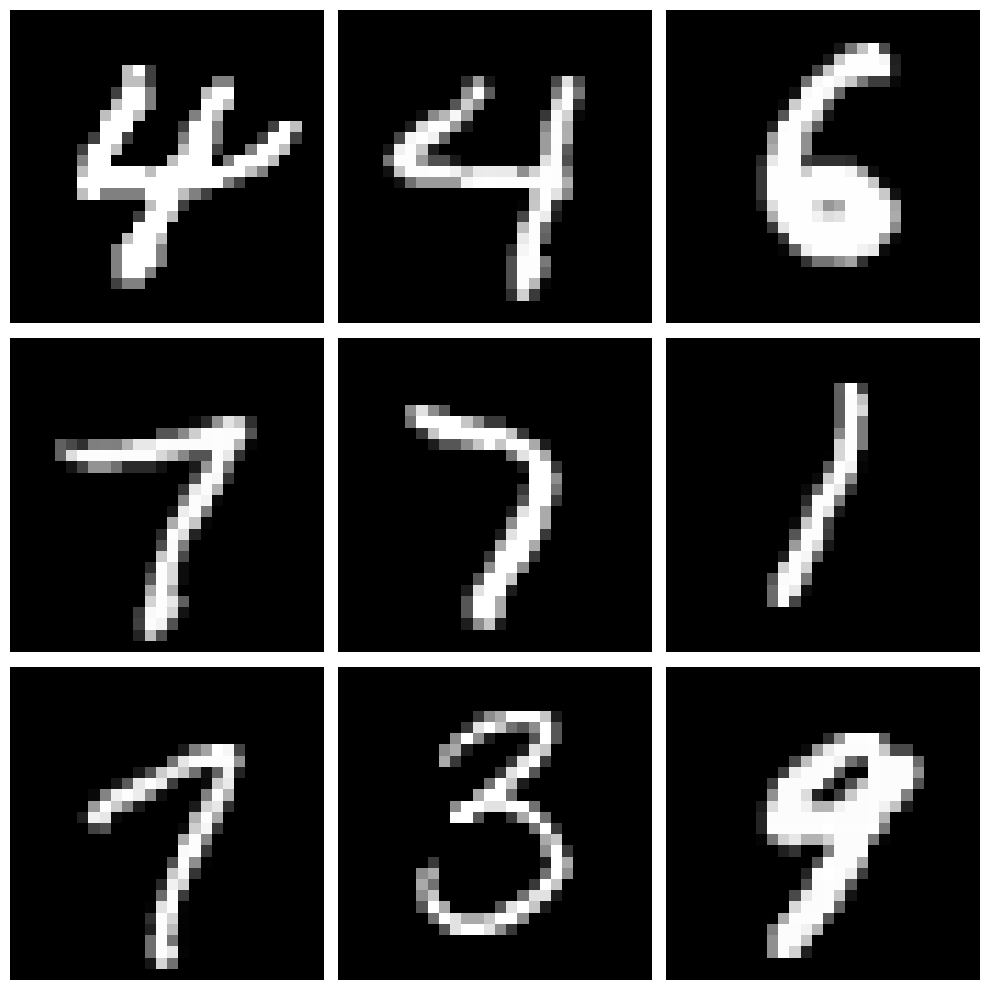

In [4]:
def get_dataloaders(batch_size: int = 128, num_workers=0):
    #transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((1,), (1,))])
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(trainset))
    train_size = len(trainset) - val_size
    trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    return trainloader, valloader, testloader

# plot the images
trainloader, valloader, testloader = get_dataloaders()
images, labels = next(iter(trainloader))
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    #print(torch.min(images[i]))
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, image_size: int = 28):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),                     
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            
            nn.Flatten(),
            nn.Linear(32 * image_size * image_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 25088),
            nn.Unflatten(1, torch.Size([32, image_size, image_size])),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = ConvAutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainloader, valloader, testloader = get_dataloaders(batch_size=512, num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(30):
    model.train()
    model.to(device)
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(torch.max(outputs), torch.max(inputs), torch.min(outputs), torch.min(inputs))
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Loss: 0.2361002749902137
Epoch 2, Loss: 0.19941013575868405
Epoch 3, Loss: 0.19065346537118263
Epoch 4, Loss: 0.18590628783753577
Epoch 5, Loss: 0.18314681550923814
Epoch 6, Loss: 0.1810059742407596
Epoch 7, Loss: 0.17923021998177183
Epoch 8, Loss: 0.17781098932027817
Epoch 9, Loss: 0.17668590869041198
Epoch 10, Loss: 0.17601715297775067
Epoch 11, Loss: 0.175105334913477
Epoch 12, Loss: 0.17421524813200565
Epoch 13, Loss: 0.17338442311007926
Epoch 14, Loss: 0.17322884436617506
Epoch 15, Loss: 0.17244776052997468
Epoch 16, Loss: 0.17213294734346105
Epoch 17, Loss: 0.1712137811044429
Epoch 18, Loss: 0.17097600105595082
Epoch 19, Loss: 0.17081718622369968
Epoch 20, Loss: 0.1702269142929544
Epoch 21, Loss: 0.1699124425649643
Epoch 22, Loss: 0.16921865401115824
Epoch 23, Loss: 0.16947730123362642
Epoch 24, Loss: 0.1689328575070868
Epoch 25, Loss: 0.16848230964325844
Epoch 26, Loss: 0.16825134957090337
Epoch 27, Loss: 0.16820936047650398
Epoch 28, Loss: 0.1675696612355557
Epoch 29, 

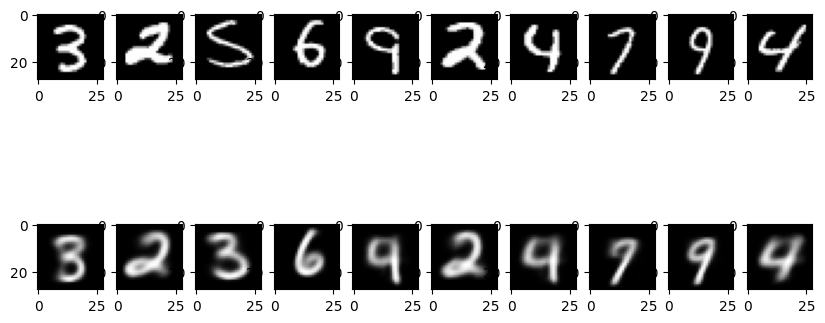

In [8]:
with torch.no_grad():
    images, _ = next(iter(trainloader))
    images = images.to(device)
    outputs = model(images)

    # Plot original and reconstructed images
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[i].reshape(28, 28).detach().cpu(), cmap='gray')
    plt.show()

## Вариативные автоэнкодеры (35%)

![img](https://www.researchgate.net/publication/365190062/figure/fig2/AS:11431281095388874@1667878234857/Structure-of-the-conditional-variational-autoencoder-CVAE.png)

Воспользуйтесь кодом из семинара (либо конволюционными автоэнкодером из прошого задания) и добавьте условия на вариативные автоэнкодеры.

1. В качестве условия используйте метки классов.
2. В энкодер и декодер добавьте условия на метки классов.


Проверьте качество модели и сравните с обычным вариативным автоэнкодером.

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim: int = 2, num_classes: int = 10, image_size: int = 28):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.image_size = 28
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        # encoder part
        self.encode1 = nn.Linear(self.image_size * self.image_size + self.num_classes, 512)
        self.encode2 = nn.Linear(512, 256)
        self.encode_mu = nn.Linear(256, self.hidden_dim)
        self.encode_logvar = nn.Linear(256, self.hidden_dim)
        # decoder part
        self.decode1 = nn.Linear(self.hidden_dim + self.num_classes, 256)
        self.decode2 = nn.Linear(256, 512)
        self.decode3 = nn.Linear(512, self.image_size * self.image_size)

    def encoder(self, x, y):
        
        
        #print (x.shape, c.shape)
        z = torch.cat([x, y], dim = 1)
        h = F.relu(self.encode1(z))
        h = F.relu(self.encode2(h))
        return self.encode_mu(h), self.encode_logvar(h)

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # logvar -> std
        eps = torch.randn_like(std)  # noise
        return mu + eps * std

    def decoder(self, z, y):

        h = F.relu(self.decode1(torch.cat([z, y],dim=1)))
        h = F.relu(self.decode2(h))
        return torch.tanh(self.decode3(h))

    def forward(self, x, y):
        
        x = x.view(-1, self.image_size * self.image_size)
        c = self.label_emb(y)
        #print(y)
        mu, log_var = self.encoder(x, c)
        z = self.sampling(mu, log_var)
        return self.decoder(z, c), mu, log_var

    def generate(self, num_samples):
        z = torch.randn(num_samples, self.hidden_dim, device=self.device)
        return self.decoder(z, z)


def loss_function(recon_x, x, mu, log_var, image_size:int = 28, num_classes:int = 10):
    BCE = F.mse_loss(recon_x, x.view(-1, image_size * image_size), reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [36]:
x = torch.randn(512, 784)
y = torch.randn(512, 10)

print (x.shape, y.shape)
z = torch.cat([x, y], dim = 1)
print (z.shape)

torch.Size([512, 784]) torch.Size([512, 10])
torch.Size([512, 794])


In [10]:
num_classes = 10

model = VariationalAutoEncoder(hidden_dim=2, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainloader, valloader, testloader = get_dataloaders(batch_size=512, num_workers=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(100):
    model.train()
    model.to(device)
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        #labels_oh = torch.nn.functional.one_hot(labels, num_classes=num_classes)
        optimizer.zero_grad()
        outputs, mu, logsigma = model(inputs, labels)
        
        loss = loss_function(outputs, inputs, mu, logsigma)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

Epoch 1, Loss: 23255.418581698803
Epoch 2, Loss: 18981.24293550532
Epoch 3, Loss: 17475.47216796875
Epoch 4, Loss: 16910.07792760971
Epoch 5, Loss: 16579.56966838431
Epoch 6, Loss: 16328.083402593085
Epoch 7, Loss: 16162.72198096742
Epoch 8, Loss: 16024.92303856383
Epoch 9, Loss: 15914.932232795878
Epoch 10, Loss: 15823.87485455452
Epoch 11, Loss: 15738.623244265293
Epoch 12, Loss: 15672.462246509309
Epoch 13, Loss: 15610.980136303191
Epoch 14, Loss: 15557.68247174202
Epoch 15, Loss: 15507.529681266622
Epoch 16, Loss: 15468.663594996675
Epoch 17, Loss: 15422.190273853059
Epoch 18, Loss: 15371.327252327128
Epoch 19, Loss: 15350.444346326463
Epoch 20, Loss: 15300.919755651596
Epoch 21, Loss: 15267.494410738032
Epoch 22, Loss: 15242.171594498006
Epoch 23, Loss: 15218.630506150266
Epoch 24, Loss: 15189.091142370346
Epoch 25, Loss: 15154.492239444813
Epoch 26, Loss: 15135.600419714096
Epoch 27, Loss: 15109.3583984375
Epoch 28, Loss: 15078.982214095744
Epoch 29, Loss: 15064.991221326463
Epoc

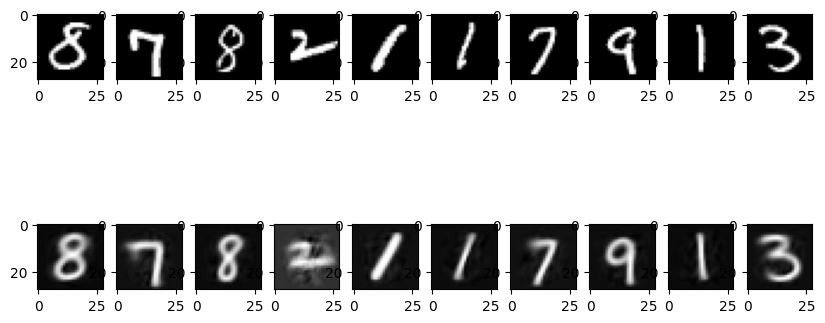

In [13]:
import matplotlib.pyplot as plt
with torch.no_grad():
    images, labels = next(iter(trainloader))
    model.to('cpu')
    outputs = model(images, labels)

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.subplot(2, 10, i + 11)
        plt.imshow(outputs[0][i].reshape(28, 28).detach().cpu(), cmap='gray')
        plt.axis('off')
    plt.show()


In [16]:
def plot_reconstructed(model, r0=(-3, 3), r1=(-3, 3),
                             n=8, number=2):
    
    fig, axs = plt.subplots(n, n)
    device = "cpu"
    
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):
           
            z = torch.Tensor([[a, b]]).to(device)
            y = model.label_emb(torch.tensor([number]).to(device))
            x_hat = model.decoder(z, y)
           
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            
            axs[i, j].imshow(x_hat, cmap='gray')
            axs[i, j].axis('off')
    plt.show()

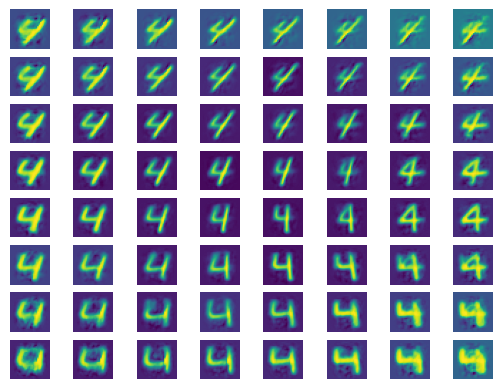

In [17]:
plot_reconstructed(model, number=4)

## GAN с условием (35%)

Воспользуйтесь кодом из семинара и добавьте условия на GAN модели.

1. В качестве условия используйте метки классов.
2. В генератор и дискриминатор добавьте условия на метки классов.

Проверьте качество модели и сравните с остальными моделями. Какую модель вы бы выбрали для работы с генерацией картинок MNIST и почему?

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, input_dim:int=100, hidden_dim:int = 256, output_dim:int = 28 * 28, class_num:int = 10):
        super().__init__()
        self.class_num = class_num
        self.label_emb = nn.Embedding(self.class_num, self.class_num)
        self.main = nn.Sequential(
            nn.Linear(input_dim + self.class_num, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh(),
        )

    def forward(self, noise, y):
        c = self.label_emb(y)
        #noise = z.view(-1, 100)
        #print(c.shape, noise.shape)
       
        x = torch.cat([noise, c], 1)
        
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self, input_dim:int=28 * 28, hidden_dim:int=512, class_num:int = 10):
        super().__init__()
        self.class_num = class_num
        self.label_emb = nn.Embedding(self.class_num, self.class_num)
        self.main = nn.Sequential(
            nn.Linear(input_dim + self.class_num, hidden_dim * 2),
            nn.LeakyReLU(0.2),  # LeakyReLU is common in GANs
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),  # Output probability of real/fake
        )

    def forward(self, image:torch.Tensor, y):
        c = self.label_emb(y)
        return self.main(torch.cat([image.view(-1, 28 * 28), c], dim = 1))  # Flatten input

In [17]:
z = torch.zeros(batch_size, 1).to(torch.int64)
print(z.shape)

torch.Size([128, 1])


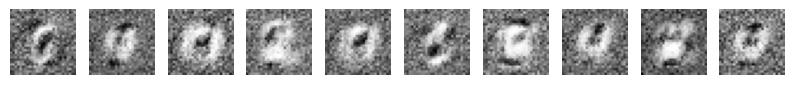

Epoch [10/200], D_Loss: 1.2018, G_Loss: 1.4362


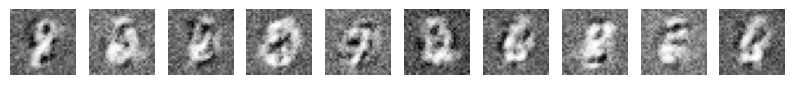

Epoch [20/200], D_Loss: 0.9932, G_Loss: 1.4978


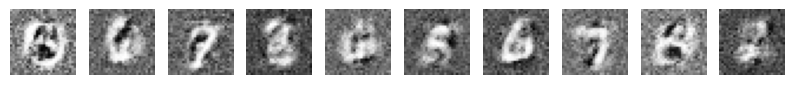

Epoch [30/200], D_Loss: 0.9419, G_Loss: 1.4108


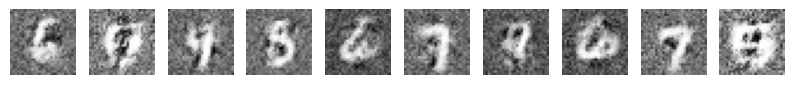

Epoch [40/200], D_Loss: 0.9452, G_Loss: 1.6252


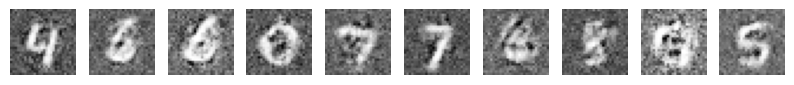

Epoch [50/200], D_Loss: 0.8927, G_Loss: 1.6204


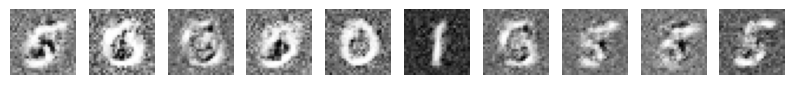

Epoch [60/200], D_Loss: 0.8245, G_Loss: 1.5657


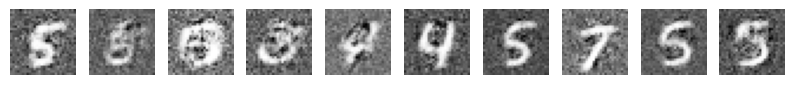

Epoch [70/200], D_Loss: 0.8536, G_Loss: 1.8718


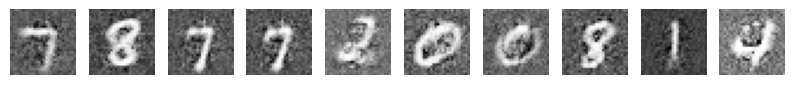

Epoch [80/200], D_Loss: 0.8292, G_Loss: 1.7606


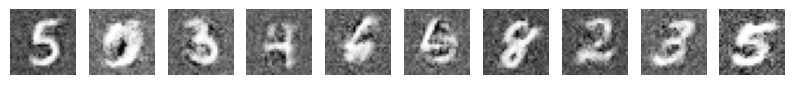

Epoch [90/200], D_Loss: 0.7615, G_Loss: 2.0194


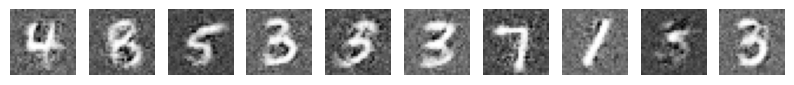

Epoch [100/200], D_Loss: 0.7278, G_Loss: 1.9978


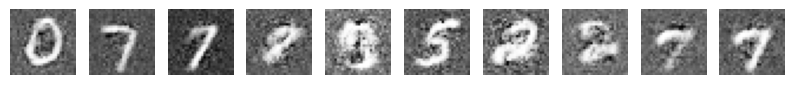

Epoch [110/200], D_Loss: 0.7730, G_Loss: 2.2520


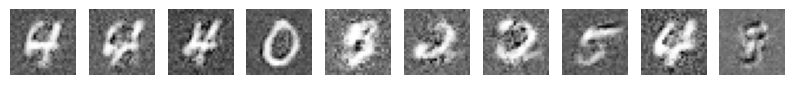

Epoch [120/200], D_Loss: 0.6958, G_Loss: 2.2846


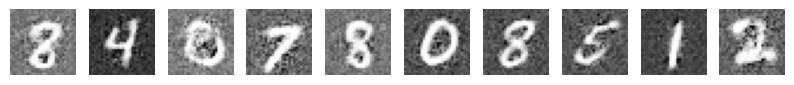

Epoch [130/200], D_Loss: 0.6505, G_Loss: 2.1775


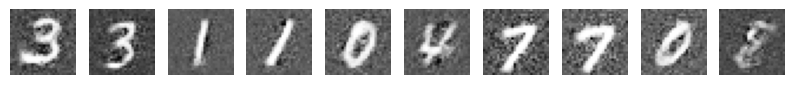

Epoch [140/200], D_Loss: 0.6946, G_Loss: 2.2703


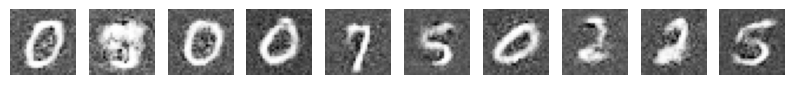

Epoch [150/200], D_Loss: 0.6210, G_Loss: 2.2506


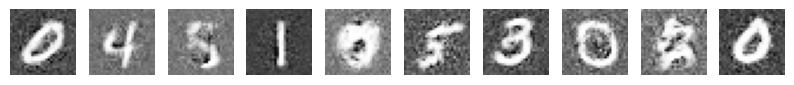

Epoch [160/200], D_Loss: 0.6894, G_Loss: 2.0329


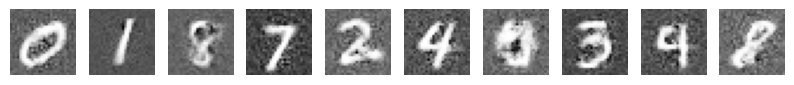

Epoch [170/200], D_Loss: 0.5426, G_Loss: 2.5856


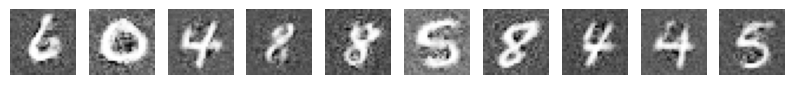

Epoch [180/200], D_Loss: 0.5838, G_Loss: 2.5615


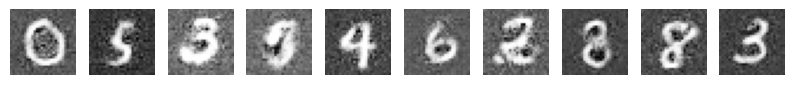

Epoch [190/200], D_Loss: 0.5336, G_Loss: 2.6160


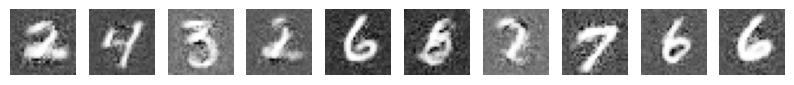

Epoch [200/200], D_Loss: 0.5204, G_Loss: 2.4242


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
class_num = 10

# возможно стоит поиграть с гиперпараметрами
#optimizer_G = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
#optimizer_D = optim.Adam(discriminator.parameters(), lr=5e-3, betas=(0.5, 0.999))

optimizer_G = optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

EPOCHS = 200
for epoch in range(EPOCHS):
    for real_images, labels in trainloader:
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        fake_pass_labels = torch.randint(low=0, high = class_num -1, size = (batch_size,1)).squeeze(1).to(device)

        real_output = discriminator(real_images, labels)
        d_loss_real = criterion(real_output, real_labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, 100).to(device)
        fake_images = generator(noise, fake_pass_labels)
        fake_output = discriminator(fake_images.detach(), fake_pass_labels)
        #print(fake_output.shape, fake_labels.shape)
        d_loss_fake = criterion(fake_output, fake_labels)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images, fake_pass_labels)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()
    if (epoch + 1) % 10 == 0:
        
        z = torch.randn(10, 100).to("cuda")

        check_labels = torch.randint(low=0, high = num_classes, size = (10,1)).squeeze(1).to("cuda")

        with torch.no_grad():
            fake_images = generator(z, check_labels).detach().cpu()
        plt.figure(figsize=(10, 2))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(fake_images[i][0], cmap="gray")
            plt.axis("off")
        plt.show()
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], D_Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G_Loss: {g_loss.item():.4f}"
        )

In [ ]:
zzz = torch.randn(10, 100)

torch.Size([10, 100]) torch.Size([10]) torch.Size([10, 10])


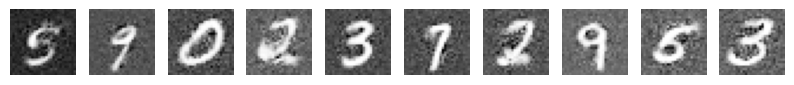

In [37]:

z = torch.randn(10, 100).to("cuda")

fake_pass_labels = torch.randint(low=0, high = num_classes, size = (10,1)).squeeze(1).to("cuda")


with torch.no_grad():
    fake_images = generator(z, fake_pass_labels).detach().cpu()
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i][0], cmap="gray")
    plt.axis("off")
plt.show()

## Решил ДЗ - дай обратную связь ;)

Надеемся, было интересно и полезно.

Пожалуйста, оставьте обратную связь по этому домашнему заданию: https://forms.gle/iY5NRn9UfaZ344rbA